In [1]:
import os
import win32com.client as win32
import numpy as npd
import matplotlib.pyplot as plt
from bayes_opt import bayesian_optimization

In [39]:
# 대상 파일 이름 지정
filename = 'ORC_Sim_230503.hsc'

In [40]:
# Active X server loading
MyObject = win32.Dispatch("HYSYS.Application")
# 대상 파일의 절대 경로 반환
filepath = os.path.abspath(filename)

# HYSYS 파일 열기
MySimCase = MyObject.SimulationCases.Open(filepath)
# HYSYS 파일을 fore ground에서 작업
MySimCase.visible = True

In [41]:
# Stream 정보 불러오기
MyStreams = MySimCase.Flowsheet.Streams

In [42]:
# Equipment 정보 불러오기
MyOperations = MySimCase.Flowsheet.Operations

In [43]:
LNG_IN = MyStreams.Item('LNG IN')

In [44]:
print('Vapor fraction: ', LNG_IN.VapourFractionValue)
print('Temperature: ', LNG_IN.TemperatureValue)
print('Pressure: ', LNG_IN.PressureValue)
print('Mass flow rate: ', LNG_IN.MassFlowValue)
print('Molar flow rate: ',LNG_IN.MolarFlowValue)
print('Heat flow rate: ', LNG_IN.HeatFlowValue)
print('Mole fractions: ',LNG_IN.ComponentMolarFractionValue)

Vapor fraction:  0.0
Temperature:  -162.0
Pressure:  130.0
Mass flow rate:  1.0
Molar flow rate:  0.055956707590770316
Heat flow rate:  -5170.546638701831
Mole fractions:  (0.0012000000000000001, 0.9115000000000001, 0.05550000000000001, 0.021600000000000005, 0.005100000000000001, 0.005100000000000001, 0.0, 0.0, 0.0, 0.0)


In [45]:
MyObject.ActiveDocument.Flowsheet.FluidPackage.ComponentList.Components.Names

('Nitrogen',
 'Methane',
 'Ethane',
 'Propane',
 'n-Butane',
 'i-Butane',
 'n-Pentane',
 'i-Pentane',
 'CF4',
 'Fluoroform')

In [46]:
Pump = MyOperations.Item('P-100')
print('Energy consumption: ',Pump.WorkValue)
print('Volume flow: ', Pump.VolumeFlowValue)

Energy consumption:  1.4087554001360114
Volume flow:  0.0022638139904500366


In [47]:
Comp1 =  MyOperations.Item('Comp1')
print('Delta P: ', Comp1.DeltaPValue)
print('Energy consumption: ', Comp1.EnergyValue)

Delta P:  400.0
Energy consumption:  0.06682724759550707


In [48]:
Turb1 = MyOperations.Item('Turb1')
print('Delta P: ', Turb1.DeltaPValue)
print('Energy consumption: ', Turb1.EnergyValue)

Delta P:  400.0
Energy consumption:  0.04214064830048917


In [49]:
HX1 = MyOperations.Item('E-100') # shell and tube type heat exchanger
print('Hot pinch point temperature: ', HX1.HotPinchTemperatureValue)
print('Cold pinch point temperature: ', HX1.ColdPinchTemperatureValue)
print('Minimum approach temperature: ', HX1.MinimumApproachValue)
print('LMTD: ', HX1.LmtdValue)
print('Heat exchange duty: ', HX1.DutyValue)

Hot pinch point temperature:  5.5275290083634445
Cold pinch point temperature:  -28.737948052442505
Minimum approach temperature:  34.26547706080595
LMTD:  37.53336233941492
Heat exchange duty:  713.3142223432806


In [50]:
MSHE1 = MyOperations.Item('MSHE1')
print('Hot pinch point temperature: ', MSHE1.HotPinchTempValue)
print('Cold pinch point temperature: ', MSHE1.ColdPinchTempValue)
print('Minimum approach temperature: ', MSHE1.MinApproachValue)
print('LMTD: ', MSHE1.LmtdValue)
print('Heat exchange duty: ', MSHE1.DutyValue)

Hot pinch point temperature:  -82.47558964043705
Cold pinch point temperature:  -92.39954337469936
Minimum approach temperature:  9.923953734262312
LMTD:  21.313180722591667
Heat exchange duty:  692.8043544936745


In [51]:
# Spreadsheet
SPRDSHT1 = MyOperations.Item('SPRDSHT-1')
P_100_pratio = SPRDSHT1.Cell('B1')
print('Cell value of B1: ',P_100_pratio.CellValue)

Cell value of B1:  4.640110177101218


In [52]:
# Define blackbox function
def black_box_function(a, b, c):
    
    # 대상 파일 이름 지정
    filename = 'ORC_Sim_230503.hsc'
    # Active X server loading
    MyObject = win32.Dispatch("HYSYS.Application")
    # 대상 파일의 절대 경로 반환
    filepath = os.path.abspath(filename)

    # HYSYS 파일 열기
    MySimCase = MyObject.SimulationCases.Open(filepath)
    # HYSYS 파일을 fore ground에서 작업
    MySimCase.visible = True
    
    # Stream 정보 불러오기
    MyStreams = MySimCase.Flowsheet.Streams
    
    # Equipment 정보 불러오기
    MyOperations = MySimCase.Flowsheet.Operations
    
    # Material
    O1 = MyStreams.Item('O1')
    
    
    # Energy
    Pump_work = MyStreams.Item('Q_PUMP2')
    Exp_work = MyStreams.Item('Q_EXP')
    
    MySimCase.Solver.CanSolve = 0
    O1.MassFlowValue = a
    O1.PressureValue = b
    P_100_pratio.CellValue = c
    MySimCase.Solver.CanSolve = 1
    
    Power_gen = Exp_work.Powervalue - Pump_work.Powervalue
    
    if HX1.MinimumApproachValue < 2:
        Obj = Power_gen/1000
    else:
        Obj = Power_gen
    return Obj

In [53]:
pbounds = {'a': (1.5, 4),     # Working Fluid Mass Flow in kg/s
            'b': (150, 300),  # Working Fluid Pressure in kPa
            'c': (2, 5),      # Pump Pressure ratio
          }

In [54]:
optimizer = bayesian_optimization.BayesianOptimization(
    f=black_box_function,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)


In [55]:

optimizer.maximize(
    init_points = 20,
    n_iter=100,
    acq = 'ei', 
    
)
obj_cur = optimizer.max['target']
params_cur = optimizer.max['params']


|   iter    |  target   |     a     |     b     |     c     |
-------------------------------------------------------------
|  1        |  0.04184  |  2.543    |  258.0    |  2.0      |
|  2        |  0.04345  |  2.256    |  172.0    |  2.277    |
|  3        |  54.01    |  1.966    |  201.8    |  3.19     |
|  4        |  0.09479  |  2.847    |  212.9    |  4.056    |
|  5        |  35.13    |  2.011    |  281.7    |  2.082    |
|  6        |  0.09825  |  3.176    |  212.6    |  3.676    |
|  7        |  64.97    |  1.851    |  179.7    |  4.402    |
|  8        |  0.1307   |  3.921    |  197.0    |  4.077    |
|  9        |  0.07158  |  3.691    |  284.2    |  2.255    |
|  10       |  58.01    |  1.598    |  175.5    |  4.634    |
|  11       |  65.82    |  1.746    |  213.2    |  4.874    |
|  12       |  0.07296  |  2.833    |  253.8    |  2.947    |
|  13       |  0.05512  |  3.216    |  275.2    |  2.055    |
|  14       |  0.1168   |  3.375    |  298.3    |  4.244    |
|  15   

In [56]:
optimizer.max

{'target': 72.79388086520541,
 'params': {'a': 1.9952479636399723,
  'b': 203.05849053960696,
  'c': 4.640110177101218}}

Text(0, 0.5, 'Power generation, kW')

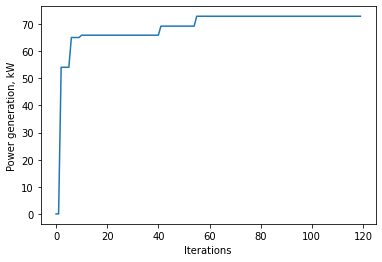

In [57]:
best_target_list = np.array([])
res_target = optimizer.space.target
best_target = res_target[0]
for i in np.arange(0, len(res_target)):
    if res_target[i]>=best_target:
        best_target = res_target[i]
        best_target_list = np.hstack([best_target_list, best_target])
    elif res_target[i]<best_target:
        best_target = best_target
        best_target_list = np.hstack([best_target_list, best_target])

plt.plot(best_target_list)
plt.xlabel('Iterations')
plt.ylabel('Power generation, kW')

In [58]:
a = optimizer.max['params']['a']
b = optimizer.max['params']['b']
c = optimizer.max['params']['c']

In [59]:
black_box_function(a, b, c)

72.79388086520541